In [ ]:
# Modified Example from Warda Rahim, QBE Insurance
# https://medium.com/@wardarahim25/zonal-statistics-using-google-earth-engine-and-visualisation-using-python-fb74cc1b1efc

In [ ]:
# Install h3 and tobler
!pip install h3 tobler pandas-gbq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 5.5 MB/s eta 0:00:00


In [ ]:
# Authenticate and Initialize Earth Engine
import ee
# Authenticate as your Qwiklabs User
ee.Authenticate()
# Initialize the library by specifying the GCP project
your_project_id = ''
ee.Initialize(project=your_project_id)

In [ ]:
# Import required libraries for dataframes and plotting
import numpy as np
import pandas as pd
import pandas_gbq
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from shapely.wkt import loads
from tobler.util import h3fy

In [ ]:
# Get the US Boundary Using Big Query Public Data
query = """SELECT * FROM `bigquery-public-data.geo_us_boundaries.national_outline`"""
conus = pandas_gbq.read_gbq(query, project_id=your_project_id)

conus = conus.iloc[:, 0].apply(loads) #get the geometric object from string
conus = gpd.GeoDataFrame(conus, geometry=conus.name, crs='epsg:4326') #convert conus to a geodataframe

Downloading: 100%|██████████|


In [ ]:
# Create Hexagonal H3 Grid For The US Region
hexgrid_us = h3fy(conus.buffer(0.01), resolution=4).reset_index()

<ipython-input-5-d62edec6a690>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hexgrid_us = h3fy(conus.buffer(0.01), resolution=4).reset_index()


In [ ]:
# Select rows with latitudes (20 to 60) and longitudes (-130 to -65)

hexgrid_us['longitude'] = hexgrid_us['geometry'].apply(lambda x: x.centroid.coords.xy[0][0])
hexgrid_us['latitude'] = hexgrid_us['geometry'].apply(lambda x: x.centroid.coords.xy[1][0])
hexgrid_us = hexgrid_us[(hexgrid_us['longitude'].between(-130, -65)) & (hexgrid_us['latitude'].between(20, 60))][['hex_id', 'geometry']]

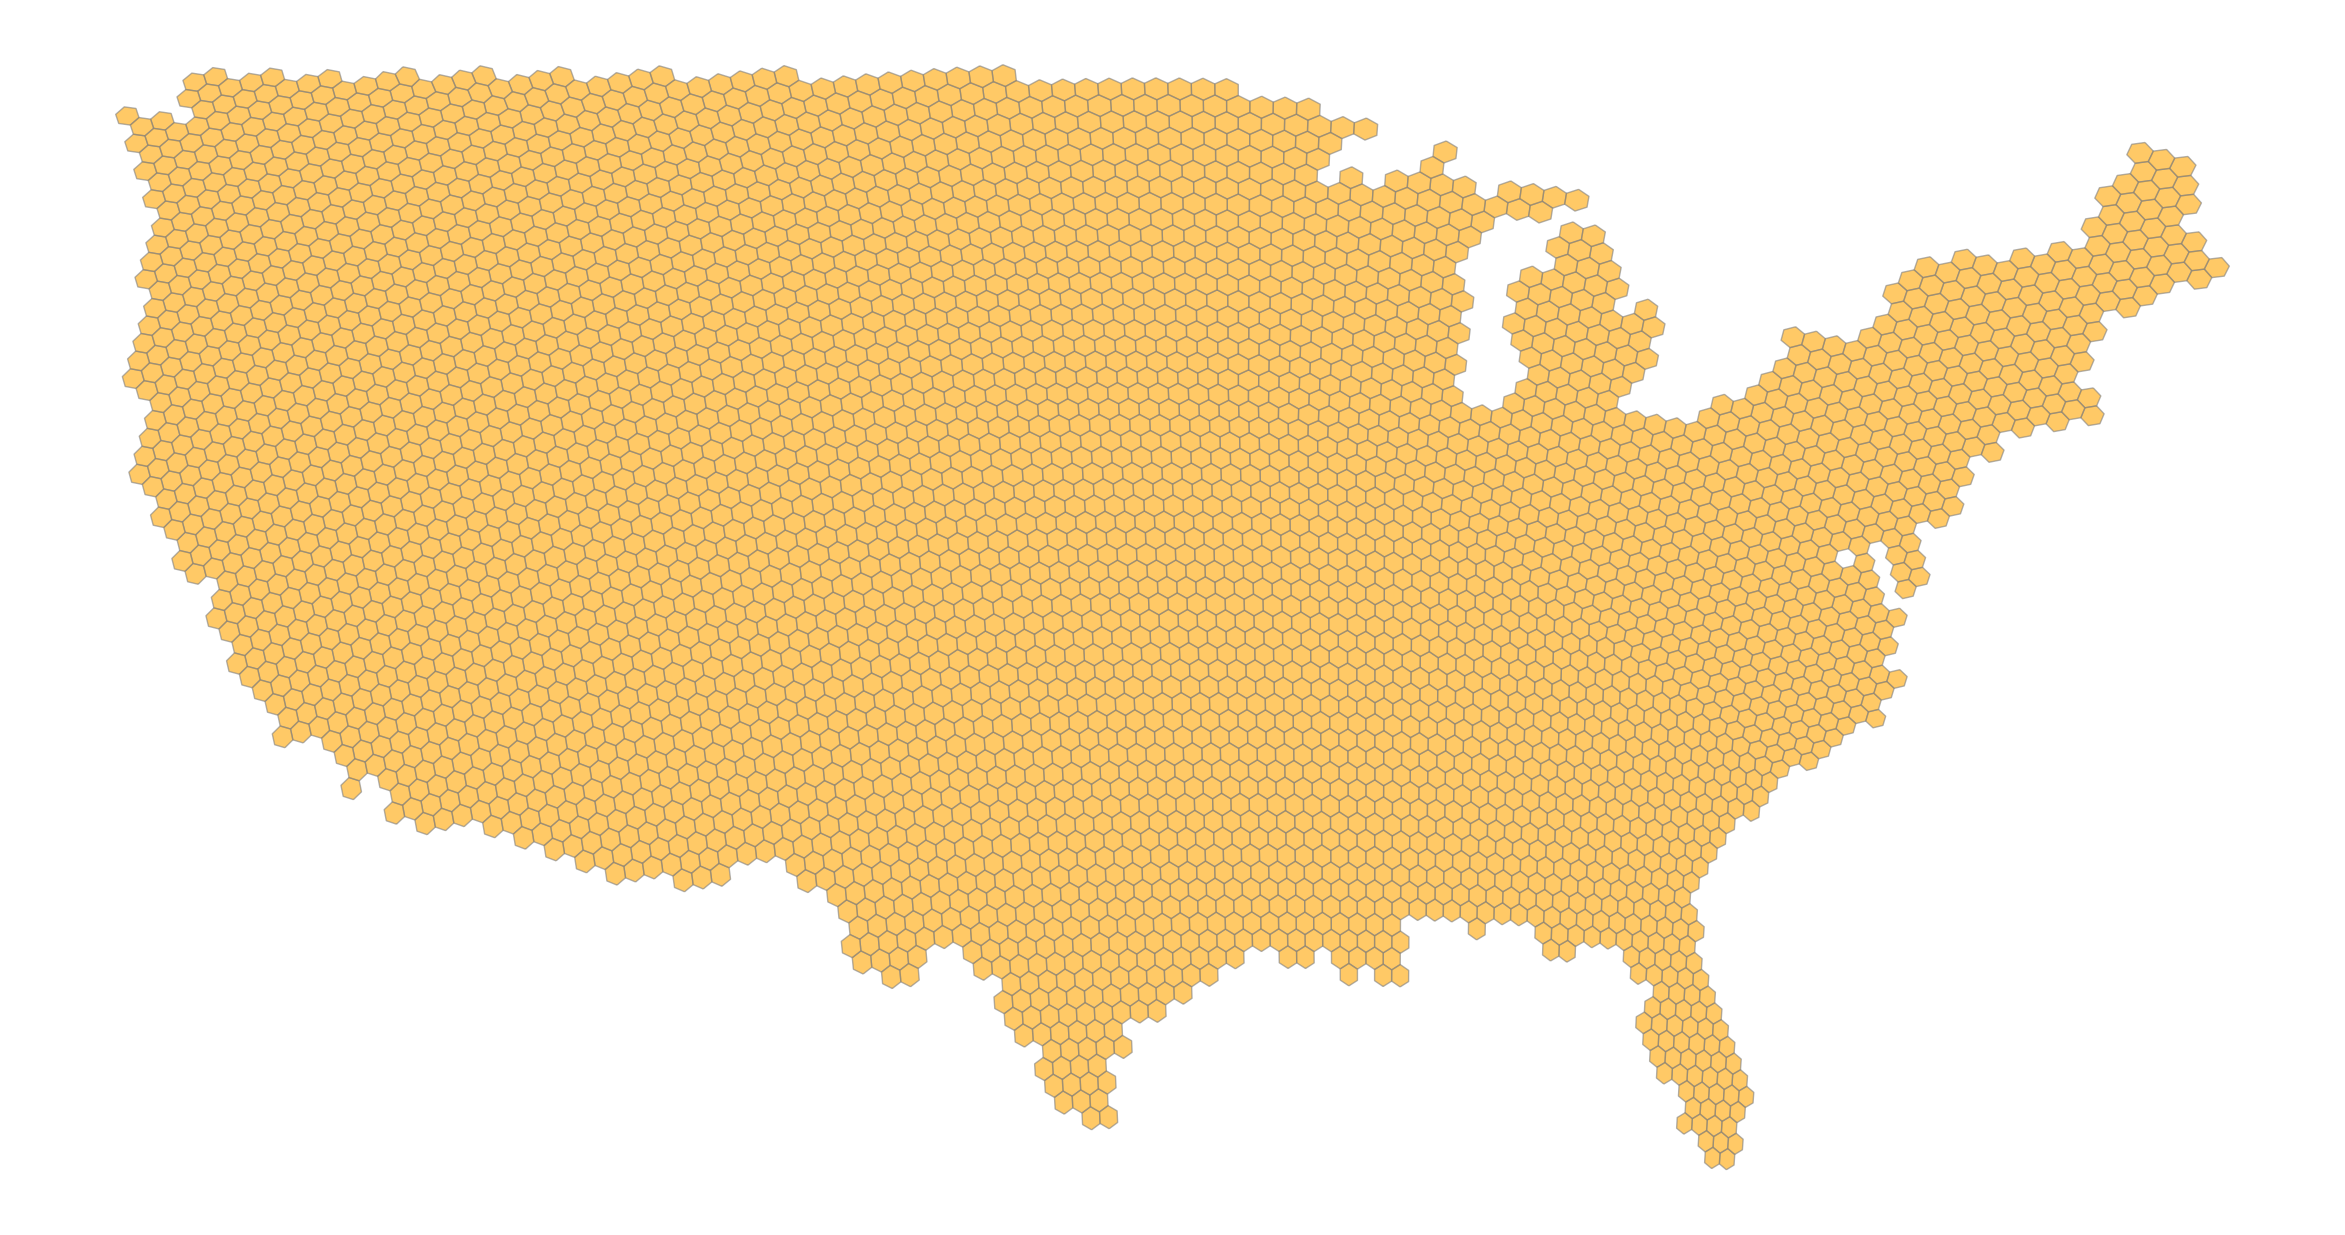

In [ ]:
# Plot the geodataframe
fig, ax = plt.subplots(figsize=(30, 26))

hexgrid_us.plot(ax=ax, color='orange', edgecolor='grey', alpha=0.6)
ax.set_axis_off()

In [ ]:
# Create an Earth Engine Feature from a Shapely geometry
def get_ee_feature(geom):
    x,y = geom.exterior.coords.xy
    coords = np.dstack((x,y)).tolist()
    g = ee.Geometry.Polygon(coords)
    return ee.Feature(g)

features = ee.FeatureCollection([get_ee_feature(x[1].geometry) for x in hexgrid_us.iterrows()])

# Create a single image from an ImageCollection and select the band you are interested in
image_collection = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY")
image = image_collection.filterDate('2015-01-01', '2023-12-31').select('temperature_2m').mean()

# Calculate Zonal Statistics
zone_stats = image.reduceRegions(collection=features, reducer=ee.Reducer.mean(), scale=11132, tileScale=1).getInfo()
zone_stats = gpd.GeoDataFrame.from_features(zone_stats, crs='epsg:4326')

/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for ECMWF/ERA5_LAND/MONTHLY! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY

  warnings.warn(warning, category=DeprecationWarning)


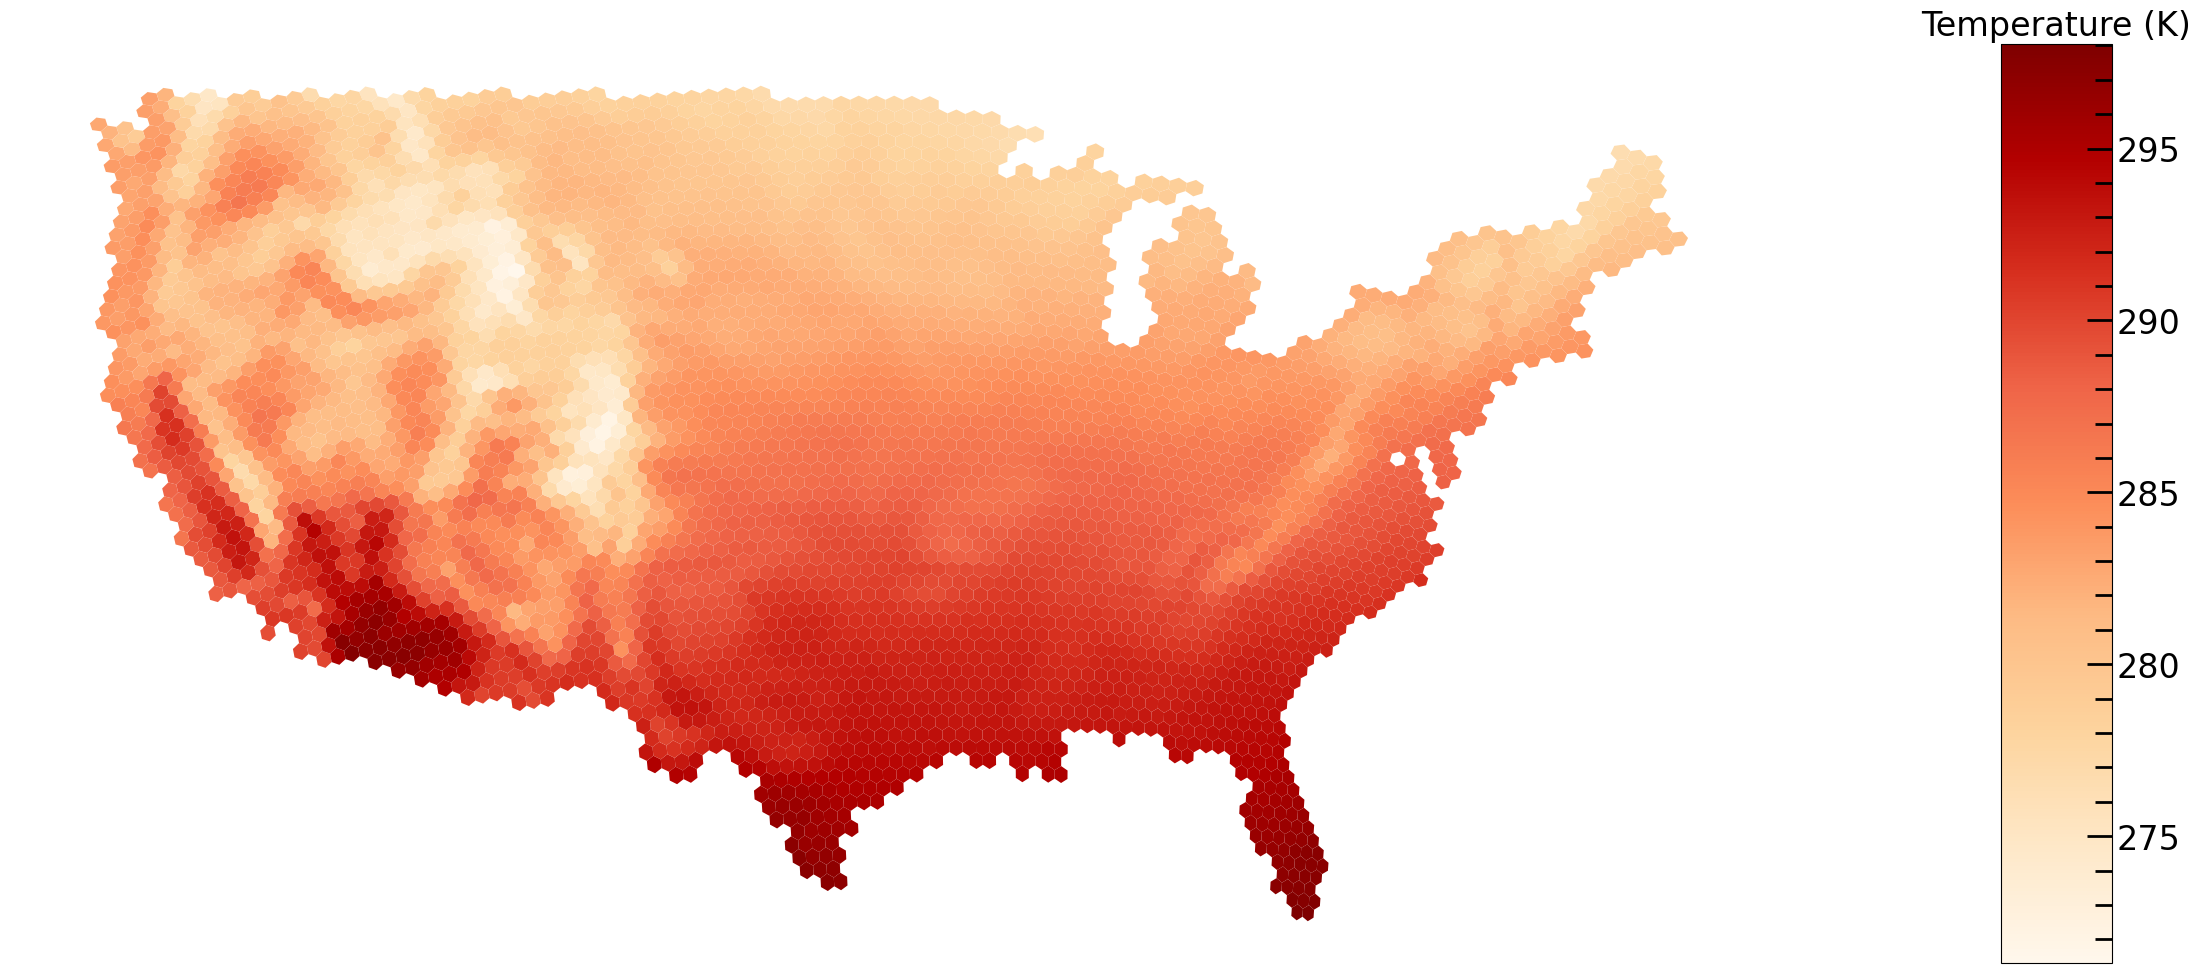

In [ ]:
fig, ax= plt.subplots(figsize=(30,26))

# Define the legend axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the US map with hexagons where the colour of each hexagon represents the mean air temperature value
zone_stats.plot(column='mean', ax=ax, cmap='OrRd', legend=True, cax=cax)

# Customise the legend
cax.minorticks_on()
cax.tick_params(which='major', direction='in', length=18, width=2, labelsize=24)
cax.tick_params(which='minor', direction='in', length=12, width=2, labelsize=24)
cax.set_title('Temperature (K)', fontsize=24)

# Turn the x-axis and y-axis off
ax.set_axis_off()